### The required Libraries

In [4]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
import scipy  #Used to upsample our image

import os
import cv2
from PIL import Image
import numpy as np

2023-02-18 08:11:43.435203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-18 08:11:43.582871: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-18 08:11:43.582884: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-18 08:11:44.121846: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

### Read and label images and get them ready for training

In [6]:
image_directory = 'cell_image_locs/'
SIZE = 224
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
label = []  #Placeholders to define add labels. We will add 1 to all parasitized images and 0 to uninfected.

parasitized_images = os.listdir(image_directory + 'Parasitized/')
for i, image_name in enumerate(parasitized_images):    #Remember enumerate method adds a counter and returns the enumerate object
    
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'Parasitized/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)

### Iterate through all images in Uninfected folder, resize to 224x224 Then save into the same numpy array 'dataset' but with label 0

In [7]:
uninfected_images = os.listdir(image_directory + 'Uninfected/')
for i, image_name in enumerate(uninfected_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'Uninfected/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)


#### Converting the list into an Numpy array

In [8]:
dataset = np.array(dataset)
label = np.array(label)

#### Let's split the data into train and test setsm

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 0)

#### Without scaling (normalize) the training may not converge. Therefore, we should normalize it so that all values are within the range of 0 and 1.

In [10]:
X_train = X_train /255.
X_test = X_test /255.

#### Let us setup the model as multiclass with total classes as 2. This way the model can be used for other multiclass classification task. Since we will be using categorical cross entropy loss, we need to convert our Y values to categorical.

In [11]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


## Define the model without the dense layers. 


#### Here, we use pre-trained VGG16 layers and add GlobalAveragePooling and dense prediction layers. You can define any model. Also, we set the first few convolutional blocks as non-trainable and only train the last convolutional block. This is just to speed up the training. You can train all layers if you want. 

In [13]:

def get_model(input_shape = (224,224,3)):
    
    vgg = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = input_shape)

    #for layer in vgg.layers[:-8]:  #Set block4 and block5 to be trainable. 
    for layer in vgg.layers[:-5]:    #Set block5 trainable, all others as non-trainable
        print(layer.name)
        layer.trainable = False #All others as non-trainable.

    x = vgg.output
    x = GlobalAveragePooling2D()(x) #Use GlobalAveragePooling and NOT flatten. 
    x = Dense(2, activation="softmax")(x)  #We are defining this as multiclass problem. 

    model = Model(vgg.input, x)
    model.compile(loss = "categorical_crossentropy", 
                  optimizer = Adam(lr=0.0001), metrics=["accuracy"])
    
    return model

model = get_model(input_shape = (224,224,3))
print(model.summary())

history = model.fit(X_train, y_train, batch_size=16, epochs=30, verbose = 1, 
                    validation_data=(X_test,y_test))

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Co

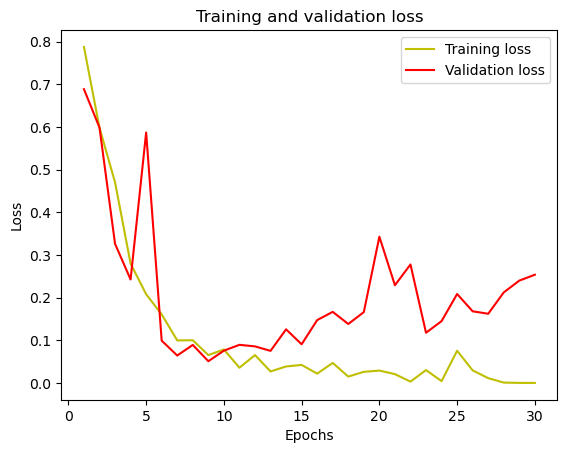

In [14]:
#Let's look at our training and validation accuracy and loss curve at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


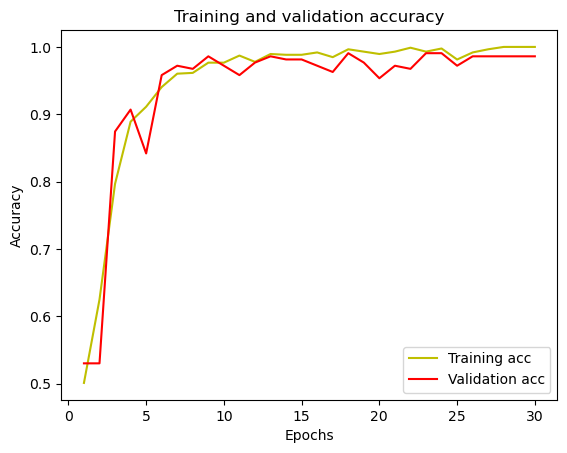

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Check model accuracy on the test data

In [16]:
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")





7/7 [==============================] - 12s 2s/step - loss: 0.2537 - accuracy: 0.9860
Accuracy =  98.60464930534363 %


#### Let's load some random image and see what the prediction will be like (Test on single image).

1/1 [==============================] - 0s 186ms/step
The prediction for this image is:  0
The actual label for this image is:  0


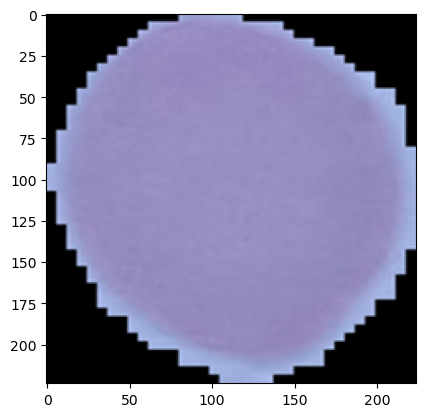

In [17]:
n=10  #Select the index of image to be loaded for testing
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", np.argmax(model.predict(input_img)))
print("The actual label for this image is: ", np.argmax(y_test[n]))


#### Let's look at the confusion matrix to analyse where the model made mistakes

7/7 [==============================] - 12s 2s/step


<AxesSubplot:>

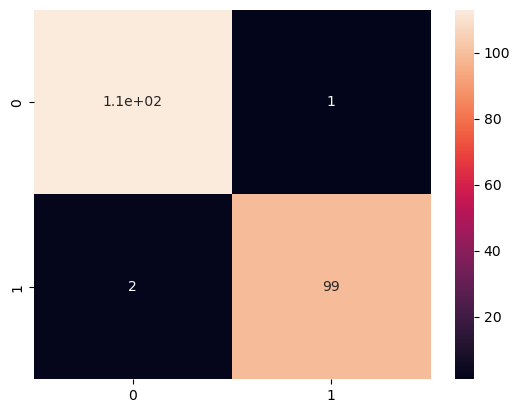

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.argmax(model.predict(X_test), axis=1)
cm=confusion_matrix(np.argmax(y_test, axis=1), y_pred)  
sns.heatmap(cm, annot=True)


#### Save all images classified as parasited so we can fetch these images later and plot heatmaps. Identify all images classified as parasitized from our prediction

In [19]:
parasited_image_idx = np.where(y_pred == 1)[0]

#### Save all images classified as parasited to a directory (optional, makes sense for large data sets) capture it in memory as an array

In [20]:
predicted_as_para=[]
for i in parasited_image_idx:
    par_img = X_test[i]
    #plt.imsave("results_classified_as_para/para_"+str(i)+".png", par_img)
    predicted_as_para.append(par_img)
    
predicted_as_para = np.array(predicted_as_para)   

In [21]:
from matplotlib.patches import Rectangle #To add a rectangle overlay to the image
from skimage.feature.peak import peak_local_max  #To detect hotspots in 2D images.

In [22]:
def plot_heatmap(img):
  
    pred = model.predict(np.expand_dims(img, axis=0))
    pred_class = np.argmax(pred)
    
    
    #Get weights for all classes from the prediction layer. Here we will get two weights from the last layer,
    #because we are doing a binary classification. One weight will be for the uninfected and the other will be 
    # for the parasitized images.
    
    last_layer_weights = model.layers[-1].get_weights()[0] #Prediction layer
    
    #Get weights for the predicted class.
    last_layer_weights_for_pred = last_layer_weights[:, pred_class] # We also need the weights for the prediction
    
    #Get output from the last conv. layer
    last_conv_layer = Model(model.input, model.get_layer("block5_conv3").output)
    last_conv_output = last_conv_layer.predict(img[np.newaxis,:,:,:])
    last_conv_output = np.squeeze(last_conv_output) # This step will make the output 14x14x512
    
    
    #Upsample/resize the last conv. output to same size as original image
    h = int(img.shape[0]/last_conv_output.shape[0]) # This is a multiplication factor (224 divided by 14)
    w = int(img.shape[1]/last_conv_output.shape[1]) # The same here
    upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output, (h, w, 1), order=1) # Let's upsampled
    # 14x14x512 into 224x224 images
    
    
    # Here we took the last convolutional layer (14x14x512) and upsampled it to 224x224. We then multiply the weights
    # from the last layer by the upsampled image. 
    heat_map = np.dot(upsampled_last_conv_output.reshape((img.shape[0]*img.shape[1], 512)), 
                 last_layer_weights_for_pred).reshape(img.shape[0],img.shape[1])
    
     #Since we have a lot of dark pixels where the edges may be thought of as 
    #high anomaly, let us drop all heat map values in this region to 0.
    #This is an optional step based on the image. 
    heat_map[img[:,:,0] == 0] = 0  #All dark pixels outside the object set to 0
    
    #Detect peaks (hot spots) in the heat map. We will set it to detect maximum 5 peaks.
    #with rel threshold of 0.5 (compared to the max peak). 
    peak_coords = peak_local_max(heat_map, num_peaks=5, threshold_rel=0.5, min_distance=10) 

    plt.imshow(img.astype('float32').reshape(img.shape[0],img.shape[1],3))
    plt.imshow(heat_map, cmap='jet', alpha=0.30)
    for i in range(0,peak_coords.shape[0]):
        print(i)
        y = peak_coords[i,0]
        x = peak_coords[i,1]
        plt.gca().add_patch(Rectangle((x-25, y-25), 50,50,linewidth=1,edgecolor='r',facecolor='none'))

    

1/1 [==============================] - 0s 143ms/step
0
1


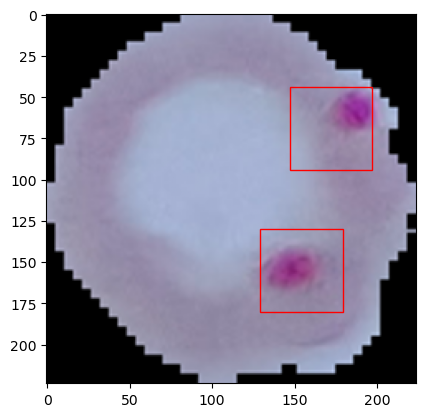

In [25]:
import random 
im = random.randint(0,predicted_as_para.shape[0]-1)
heat_map =plot_heatmap(predicted_as_para[im])

img = predicted_as_para[im]
plt.imshow(predicted_as_para[im])


In [ ]:
`